<a href="https://colab.research.google.com/github/bennng/MLDeployDemo/blob/master/MlDeployDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Convolutional Network Lab Exercise 
1. Convolutional network classifier
2. Saving the Model to a file
3. Loading and calling the model from the file

Credits: Starter code is based on the work by Stemplicity https://www.youtube.com/watch?v=zpKm8OxDBwE&t=988s
This was an early lab for me to understand the workflow for developing saving and deploying a model to production.

Importing the Tensorflow libraries and printing to verify the version of TF

In [0]:
import tensorflow as tf
from tensorflow import keras 
print(tf.__version__)

Importing other needed libraries numpy for the math, matplotlib for the charts and displaying the data, os and subprocess for supporting functions.

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import subprocess

Here we download the MNist dataset. The idea is to be able to classify images of clothing based on this images from this data set.

In [6]:


fashion_mnist = keras.datasets.fashion_mnist

(trn_images, trn_labels), (tst_images, tst_labels) = fashion_mnist.load_data()

trn_images = trn_images / 255.0
tst_images = tst_images / 255.0

trn_images = trn_images.reshape(trn_images.shape[0], 28, 28, 1)
tst_images = tst_images.reshape(tst_images.shape[0], 28, 28, 1)
# Specifying the classes for the problem
class_names = ['tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot' ]
print('\ntrn_images.shape: {}, of  {}'.format(trn_images.shape, trn_images.dtype))
print('tst_images.shape: {}, of  {}'.format(tst_images.shape, tst_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

trn_images.shape: (60000, 28, 28, 1), of  float64
tst_images.shape: (10000, 28, 28, 1), of  float64


Here we are creating the Model. Using keras we build a convolutional model. Model uses the 'relu' activation that takes in an image with the dimensions of 28 by 28 and a SoftMax activation function. 

In [0]:
 model = keras.Sequential([
                          keras.layers.Conv2D(input_shape=(28, 28, 1), filters=8, kernel_size=3, 
                                              strides=2, activation='relu', name='Conv1'),
                          keras.layers.Flatten(),
                          keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
                          ])
model.summary()
testing = False
epochs = 20
# This is where we train the model. Model uses the AdamOptimizer for training 
model.compile(optimizer=tf.train.AdamOptimizer(), 
             loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(trn_images, trn_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(tst_images, tst_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_3 (Flatten)          (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 135us/sample - loss: 0.5526 - acc: 0.8076
Epoch 2/20
60000/60000 [==============================] - 8s 136us/sample - loss: 0.4152 - acc: 0.8536
Epoch 3/20
60000/60000 [==============================] - 8s 133us/sample - loss: 0.3794 - acc: 0.8667
Epoch 4/20
60000/60000 [========================

Once the training is complete we save the trained model to a directory. This saved file can then be loaded from another service to make predictions


In [0]:
import tempfile

Model_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(Model_DIR, str(version))
print('export_path = []\n'.format(export_path))
if os.path.isdir(export_path):
  print('\Aready saved a model, cleaning up\n')
  !rm - r{export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs = {'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\Saved Model:')
!ls -l {export_path}

export_path = []

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/1/saved_model.pb
\Saved Model:
total 248
-rw-r--r-- 1 root root 248618 Feb  3 08:37 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb  3 08:37 variables


Documentation of specification on trained models

In [0]:

!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input_3:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax_3/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax_3/Softmax:0
  Method name is: tensorflow/serving/predict


Download Tensorflow Serving to serve your saved model.

In [0]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   8837      0 --:--:-- --:--:-- --:--:--  8837
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:9 https://developer.d

Installing the TF server to serve the model

In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 140 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.0.0 [140 MB]
Fetched 140 MB in 3s (53.6 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.0.0_all.deb ...
Unpacking tensorflow-model-server (2.0.0) ...
Setting up tensorflow-model-server (2.0.0) ...


In [0]:
os.environ['MODEL_DIR'] = Model_DIR

Running the bash command to support background processes

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


Check the end of the log to verify installed and started

In [0]:
!tail server.log

2020-01-04 23:00:14.101504: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-01-04 23:00:14.102713: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 23:00:14.115343: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2020-01-04 23:00:14.128712: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 28556 microseconds.
2020-01-04 23:00:14.129238: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-01-04 23:00:14.129335: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-01-04 23:00:14.130388: I tensorflow_serv

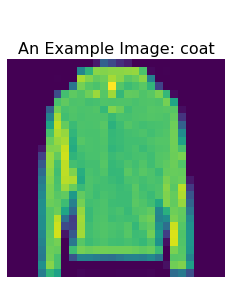

In [0]:


def show(idx, title):
  plt.figure()
  plt.imshow(tst_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(tst_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[tst_labels[rando]]))

In [0]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": tst_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


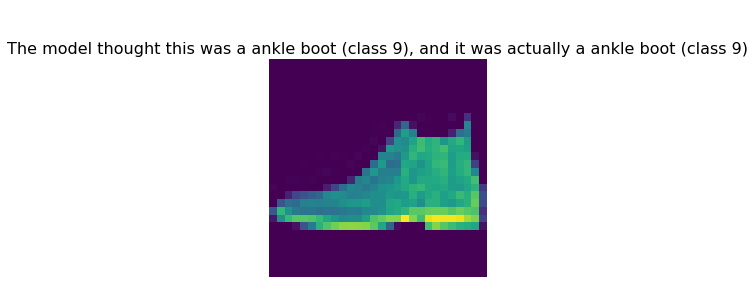

In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], tst_labels[0], class_names[np.argmax(predictions[0])], tst_labels[0]))

IndexError: ignored

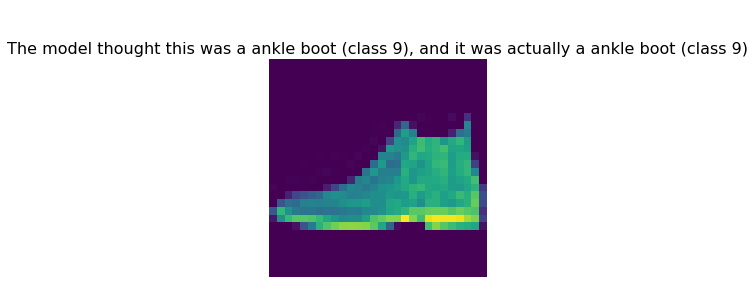

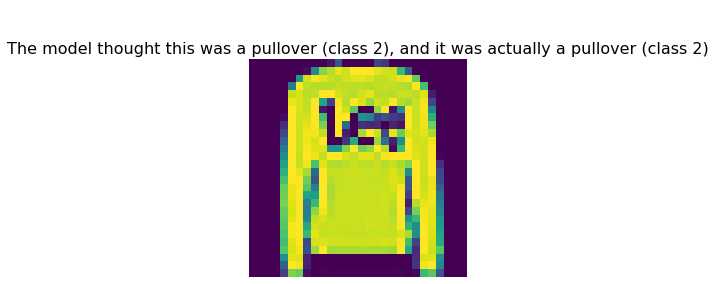

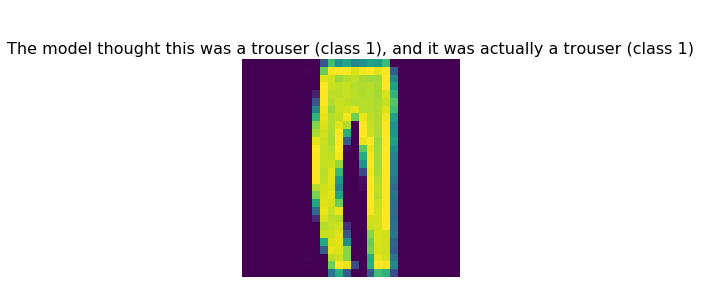

In [0]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,4):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], tst_labels[i], class_names[np.argmax(predictions[i])], tst_labels[i]))